# C3.ai COVID-19 Data Lake Quickstart in Python  
This Jupyter notebook shows some examples of how to access and use each of the [C3.ai COVID-19 Data Lake](https://c3.ai/covid/) APIs. These examples show only a small piece of what you can do with the C3.ai COVID-19 Data Lake, but will get you started with performing your own exploration. See the [API documentation](https://c3.ai/covid-19-api-documentation/) for more details.

Please contribute your questions, answers and insights on [Stack Overflow](https://www.stackoverflow.com). Tag `c3ai-datalake` so that others can view and help build on your contributions. For support, please send email to: [covid@c3.ai](mailto:covid@c3.ai).

## Table of Contents
- [Helper methods for accessing the API](#helpers)
- [Access OutbreakLocation data](#outbreaklocation)
- [Access LineListRecord data](#linelistrecord)
- [Join BiologicalAsset and Sequence data](#biologicalasset)
- [Access BiblioEntry data](#biblioentry)
- [Join TherapeuticAsset and ExternalLink data](#therapeuticasset)

Import the [requests](https://requests.readthedocs.io/en/master/), [pandas>=1.0.0](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/3.2.1/index.html), and [scipy](https://www.scipy.org/) libraries before using this notebook.

In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gamma
import numpy as np

Ensure that you have a recent version of pandas (>= 1.0.0).

In [2]:
print("pandas version", pd.__version__)
assert pd.__version__[0] >= "1", "To use this notebook, upgrade to the newest version of pandas. See https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html for details."


pandas version 1.0.1


<a id="helpers"></a>
## Helper methods for accessing the API

The helper methods below convert a JSON response from the C3.ai APIs to a Pandas DataFrame. Please run this cell before using the quickstart examples.

In [3]:
def read_data_json(typename, api, body):
    """
    read_data_json directly accesses the C3.ai COVID-19 Data Lake APIs using the requests library, 
    and returns the response as a JSON, raising an error if the call fails for any reason.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    api: The API you want to access, either 'fetch' or 'evalmetrics'.
    body: The spec you want to pass. For examples, see the API documentation.
    """
    response = requests.post(
        "https://api.c3.ai/covid/api/1/" + typename + "/" + api, 
        json = body, 
        headers = {
            'Accept' : 'application/json', 
            'Content-Type' : 'application/json'
        }
    )
    response.raise_for_status()
    
    return response.json()

def fetch(typename, body, get_all = False, remove_meta = True):
    """
    fetch accesses the Data Lake using read_data_json, and converts the response into a Pandas dataframe. 
    fetch is used for all non-timeseries data in the Data Lake, and will call read_data as many times 
    as required to access all of the relevant data for a given typename and body.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    body: The spec you want to pass. For examples, see the API documentation.
    get_all: If True, get all records and ignore any limit argument passed in the body. If False, use the limit argument passed in the body. The default is False.
    remove_meta: If True, remove metadata about each record. If False, include it. The default is True.
    """
    if get_all:
        has_more = True
        offset = 0
        limit = 2000
        df = pd.DataFrame()

        while has_more:
            body['spec'].update(limit = limit, offset = offset)
            response_json = read_data_json(typename, 'fetch', body)
            new_df = pd.json_normalize(response_json['objs'])
            df = df.append(new_df)
            has_more = response_json['hasMore']
            offset += limit
            
    else:
        response_json = read_data_json(typename, 'fetch', body)
        df = pd.json_normalize(response_json['objs'])
        
    if remove_meta:
        df = df.drop(columns = [c for c in df.columns if ('meta' in c) | ('version' in c)])
    
    return df
    
def evalmetrics(typename, body, remove_meta = True):
    """
    evalmetrics accesses the Data Lake using read_data_json, and converts the response into a Pandas dataframe.
    evalmetrics is used for all timeseries data in the Data Lake.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    body: The spec you want to pass. For examples, see the API documentation.
    remove_meta: If True, remove metadata about each record. If False, include it. The default is True.
    """
    response_json = read_data_json(typename, 'evalmetrics', body)
    df = pd.json_normalize(response_json['result'])
    
    # get the useful data out
    df = df.apply(pd.Series.explode)
    if remove_meta:
        df = df.filter(regex = 'dates|data|missing')
    
    # only keep one date column
    date_cols = [col for col in df.columns if 'dates' in col]
    keep_cols =  date_cols[:1] + [col for col in df.columns if 'dates' not in col]
    df = df.filter(items = keep_cols).rename(columns = {date_cols[0] : "dates"})
    df["dates"] = pd.to_datetime(df["dates"])
    
    return df

<a id="outbreaklocation"></a>
## Access OutbreakLocation data

OutbreakLocation stores location data such as countries, provinces, cities, where COVID-19 outbeaks are recorded. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/OutbreakLocation) and [Excel file of available locations](https://c3.ai/wp-content/uploads/2020/04/C3-ai-Location-IDs.xlsx) for more details.

In [4]:
# Fetch facts about Germany
locations = fetch(
    "outbreaklocation",
    {
        "spec" : {
            "filter" : "id == 'Germany'"
        }
    }
)

locations

,population2018,id,name,typeIdent,location.value.id,location.timestamp,fips.id
0,82927922,Germany,Germany,EP_LOC,Germany,2020-05-09T00:00:00Z,DE


In [5]:
# Total number of confirmed cases, deaths, and recoveries in Santa Clara, California
today = pd.Timestamp.now().strftime("%Y-%m-%d")

casecounts = evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : ["SantaClara_California_UnitedStates"],
            "expressions" : ["JHU_ConfirmedCases", "JHU_ConfirmedDeaths", "JHU_ConfirmedRecoveries"],
            "start" : "2020-01-01",
            "end" : today,
            "interval" : "DAY",
        }
    }
)

casecounts

,dates,SantaClara_California_UnitedStates.JHU_ConfirmedCases.data,SantaClara_California_UnitedStates.JHU_ConfirmedCases.missing,SantaClara_California_UnitedStates.JHU_ConfirmedDeaths.data,SantaClara_California_UnitedStates.JHU_ConfirmedDeaths.missing,SantaClara_California_UnitedStates.JHU_ConfirmedRecoveries.data,SantaClara_California_UnitedStates.JHU_ConfirmedRecoveries.missing
0,2020-01-01,0,0,0,0,0,100
0,2020-01-02,0,0,0,0,0,100
0,2020-01-03,0,0,0,0,0,100
0,2020-01-04,0,0,0,0,0,100
0,2020-01-05,0,0,0,0,0,100
...,...,...,...,...,...,...,...
0,2020-05-05,2255,0,121,0,0,0
0,2020-05-06,2268,0,126,0,0,0
0,2020-05-07,2281,0,127,0,0,0
0,2020-05-08,2290,0,128,0,0,0


Plot these counts.

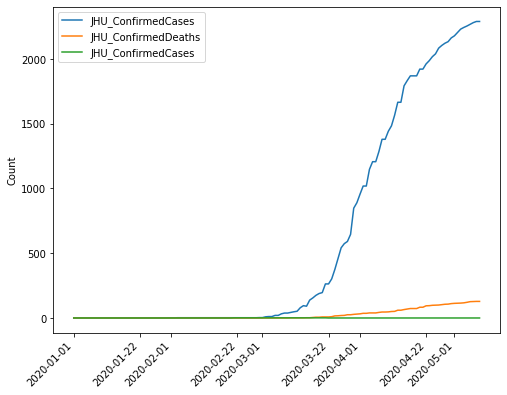

In [7]:
plt.figure(figsize = (8, 6))
plt.plot(
    casecounts["dates"],
    casecounts["SantaClara_California_UnitedStates.JHU_ConfirmedCases.data"],
    label = "JHU_ConfirmedCases"
)
plt.plot(
    casecounts["dates"],
    casecounts["SantaClara_California_UnitedStates.JHU_ConfirmedDeaths.data"],
    label = "JHU_ConfirmedDeaths"
)
plt.plot(
    casecounts["dates"],
    casecounts["SantaClara_California_UnitedStates.JHU_ConfirmedRecoveries.data"],
    label = "JHU_ConfirmedCases"
)
plt.legend()
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Count")
plt.show()

Export case counts as a .csv file.

In [ ]:
# Uncomment the line below to export the DataFrame as a .csv file
# casecounts.to_csv("casecounts.csv")

<a id="linelistrecord"></a>
## Access LineListRecord data

LineListRecord stores individual-level crowdsourced information from laboratory-confirmed COVID-19 patients. Information includes gender, age, symptoms, travel history, location, reported onset, confirmation dates, and discharge status. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/LineListRecord) for more details.

In [6]:
# Fetch the line list records tracked by MOBS Lab
records = fetch(
    "linelistrecord",
    {
        "spec" : {
            "filter" : "lineListSource == 'DXY'"
        }
    },
    get_all = True
)

records

,age,gender,symptomStartDate,exposureStartDate,exposureEndDate,hospitalAdmissionDate,caseConfirmationDate,livesInGroundZero,traveledToGroundZero,traveler,...,outcome,didDie,didRecover,recordSource,lineListSource,hasTravelHistory,id,location.id,caseInCountry,symptoms
0,66.0,male,2020-01-03T00:00:00Z,2019-12-29T00:00:00Z,2020-01-04T00:00:00Z,2020-01-11T00:00:00Z,2020-01-20T00:00:00Z,False,False,False,...,open,False,False,Shenzhen Municipal Health Commission: http://w...,DXY,False,1,ShenzhenGuangdong_China,NaN,NaN
1,56.0,male,2020-01-16T00:00:00Z,2020-01-08T00:00:00Z,2020-01-16T00:00:00Z,2020-01-20T00:00:00Z,2020-01-21T00:00:00Z,False,False,False,...,open,False,False,Beijing Municipal Health Commission: http://wj...,DXY,False,10,Beijing_China,NaN,NaN
2,70.0,male,2020-01-15T00:00:00Z,NaN,NaN,2020-01-19T00:00:00Z,2020-01-24T00:00:00Z,False,False,False,...,open,False,False,央视新闻: https://m.weibo.cn/status/4464497211305006?,DXY,False,100,WuhanHubei_China,NaN,NaN
3,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,1000,UnitedStates,56.0,NaN
4,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,1001,UnitedStates,57.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,995,UnitedStates,51.0,NaN
1393,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,996,UnitedStates,52.0,NaN
1394,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,997,UnitedStates,53.0,NaN
1395,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,998,UnitedStates,54.0,NaN


What are the most common symptoms in this dataset?

In [ ]:
# Get all the symptoms, which are initially comma-separated
symptom_df = records.copy()
symptom_df["symptoms"] = symptom_df["symptoms"].str.split(", ")
symptom_df = symptom_df.explode("symptoms")
symptom_df = symptom_df.dropna(subset = ["symptoms"])
symptom_freq = symptom_df.groupby(["symptoms"]).agg("count")[["id"]].sort_values("id")

# Plot the data
plt.figure(figsize = (10, 6))
plt.bar(symptom_freq.index, symptom_freq["id"])
plt.xticks(rotation = 90)
plt.xlabel("Symptom")
plt.ylabel("Number of patients")
plt.title("Common COVID-19 symptoms")
plt.show()

If a patient is symptomatic and later hospitalized, how long does it take for them to become hospitalized after developing symptoms?

In [ ]:
# Get the number of days from development of symptoms to hospitalization for each patient
hospitalized = records.dropna(subset = ["hospitalAdmissionDate", "symptomStartDate"])
hospitalization_time = np.array(
    pd.to_datetime(hospitalized['hospitalAdmissionDate']) - pd.to_datetime(hospitalized['symptomStartDate'])
).astype('timedelta64[D]').astype('float')
hospitalization_time = hospitalization_time[hospitalization_time >= 0]

# Hospitalization time of 0 days is replaced with 0.1 to indicate near-immediate hospitalization
hospitalization_time[hospitalization_time <= 0.1] = 0.1

# Fit a gamma distribution
a, loc, scale = gamma.fit(hospitalization_time, floc = 0)
dist = gamma(a, loc, scale)

# Plot the results
x = np.linspace(0, np.max(hospitalization_time), 1000)
n_bins = int(np.max(hospitalization_time) + 1)
print(n_bins)

plt.figure(figsize = (10, 6))
plt.hist(
    hospitalization_time, 
    bins = n_bins, 
    range = (0, np.max(hospitalization_time)), 
    density = True, 
    label = "Observed"
)
plt.plot(x, dist.pdf(x), 'r-', lw=5, alpha=0.6, label = 'Gamma distribution')
plt.ylim(0, 0.5)
plt.xlabel("Days from development of symptoms to hospitalization")
plt.ylabel("Proportion of patients")
plt.title("Distribution of time to hospitalization")
plt.legend()
plt.show()

<a id="biologicalasset"></a>
## Join BiologicalAsset and Sequence data

BiologicalAsset stores the metadata of the genome sequences collected from SARS-CoV-2 samples in the National Center for Biotechnology Information Virus Database. Sequence stores the genome sequences collected from SARS-CoV-2 samples in the National Center for Biotechnology Information Virus Database. See the API documentation for [BiologicalAsset](https://c3.ai/covid-19-api-documentation/#tag/BiologicalAsset) and [Sequence](https://c3.ai/covid-19-api-documentation/#tag/Sequence) for more details.

In [ ]:
# Join data from BiologicalAsset & Sequence
sequences = fetch(
  "biologicalasset",
  {
    "spec" : {
      "include" : "this, sequence.sequence",
      "filter" : "exists(sequence.sequence)"
    }
  },
  get_all = True
)

sequences

<a id="biblioentry"></a>
## Access BiblioEntry data

BiblioEntry stores the metadata about the journal articles in the CORD-19 Dataset. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/BiblioEntry) for more details.

In [ ]:
# Fetch metadata for the first two thousand (2000) BiblioEntry journal articles approved for commercial use
# Note that 2000 records are returned; the full dataset can be accessed using the get_all = True argument in fetch
bibs = fetch(
  "biblioentry",
  {
      "spec" : {
          "filter" : "hasFullText == true"
      }
  }
)

# Sort them to get the most recent articles first
bibs["publishTime"] = pd.to_datetime(bibs["publishTime"])
bibs = bibs.sort_values("publishTime", ascending = False)

bibs

Use GetArticleMetadata to access the full-text of these articles, or in this case, the first page text.

In [ ]:
bib_id = bibs.loc[0, "id"] 
print(bib_id)

article_data = read_data_json(
    "biblioentry",
    "getarticlemetadata",
    {
        "ids" : [bib_id]
    }
)

article_data["value"]["value"][0]["body_text"][0]["text"]

<a id="therapeuticasset"></a>
## Join TherapeuticAsset and ExternalLink data

TherapeuticAsset stores details about the research and development (R&D) of coronavirus therapies, for example, vaccines, diagnostics, and antibodies. ExternalLink stores website URLs cited in the data sources containing the therapies stored in the TherapeuticAssets C3.ai Type. See the API documentation for [TherapeuticAsset](https://c3.ai/covid-19-api-documentation/#tag/TherapeuticAsset) and [ExternalLink](https://c3.ai/covid-19-api-documentation/#tag/ExternalLink) for more details.

In [ ]:
# Join data from TherapeuticAsset and ExternalLink (productType, description, origin, and URL links)
assets = fetch(
  "therapeuticasset",
  {
      "spec" : {
          "include" : "productType, description, origin, links.url",
          "filter" : "origin == 'Milken'"
      }
  }
)

assets = assets.explode("links")
assets["links"] = [link["url"] if type(link) == dict and "url" in link.keys() else None for link in assets["links"]]
assets